# PHYS 6260: Homework 6, Sachin Venkatesh

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import multiprocessing as mp
import os

## Problem 1

Parallel Monte Carlo Solver (45 points total): Here you will write a Monte Carlo solver that simulates radioactive decay. Your code should be able to run in serial (1 core) and in parallel, using Python's thread pool in the multiprocessing module.

Consider the radioactive decay of ${ }^{8} \mathrm{Li}$. This isotope of $\mathrm{Li}$ is unstable and has a relatively long half-life $\left(\tau_{1 / 2}\right)$ of $838.7(3) \mathrm{ms} .{ }^{8} \mathrm{Li}$ undergoes a $\beta^{-}$ decay and produces daughter isotope of ${ }^{8} \mathrm{Be}$. The decay rate can be described using a simple differential equation:

$$
\frac{d N}{d t}=-\lambda N
$$

where $\lambda$ is the decay rate. By integrating Equation 1, we obtain:

$$
N=N_{0} e^{-\lambda t}
$$

where $N_{0}$ is the initial number of particles. The decay rate, $\lambda$, can be rewritten in terms of the half-life: $\lambda=\ln (2) / \tau_{1 / 2}$.

(a) (15 points) Write a function to model the radioactive decay of ${ }^{8} \mathrm{Li}$ particles using the Metropolis algorithm. Consider a system with $N_{0}=1,000$ and model the decay up to a maximum time of 1 second. You first want to create an appropriately spaced time grid where we can see the decay occur. Within each timestep, you should start with the undecayed nuclei from the previous timestep and decide whether each decays within the proceeding timestep given by the probability shown in Equation 2.


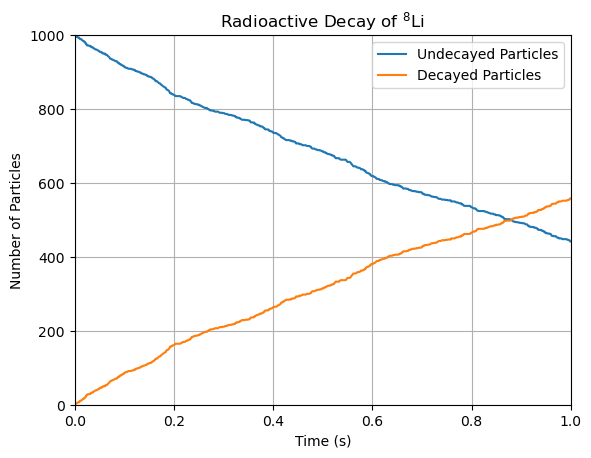

In [2]:
# Parameters
N0 = 1000
half_life = 0.8387  
max_time = 1
dt = 0.001

def metropolis_decay(N0, half_life, max_time, dt):
    decay_constant = np.log(2) / half_life
    time_points = np.arange(0, max_time, dt)
    num_steps = len(time_points)
    decayed_particles = np.zeros(num_steps)
    undecayed_particles = np.ones(num_steps) * N0

    for i in range(1, num_steps):
        undecayed_previous = int(undecayed_particles[i - 1])
        decayed_previous = int(decayed_particles[i - 1])

        decay_probability = 1 - np.exp(-decay_constant * dt)

        random_numbers = np.random.rand(undecayed_previous)
        decayed_this_step = random_numbers < decay_probability # Boolean array for decayed particles

        undecayed_particles[i] = undecayed_previous - np.sum(decayed_this_step)
        decayed_particles[i] = decayed_previous + np.sum(decayed_this_step)

    return time_points, undecayed_particles, decayed_particles


time_points, undecayed_particles, decayed_particles = metropolis_decay(N0, half_life, max_time, dt)

# Plot the results
plt.plot(time_points, undecayed_particles, label='Undecayed Particles')
plt.plot(time_points, decayed_particles, label='Decayed Particles')
plt.xlabel('Time (s)')
plt.ylabel('Number of Particles')
plt.title('Radioactive Decay of $^8$Li')
plt.xlim(0, max_time)
plt.ylim(0, N0)
plt.grid()
plt.legend()
plt.show()


(b) (15 points) Use the function that you wrote in part (a) to model the decay in serial. Repeat the decay process for all 1,000 initial particles 10 times and create a plot of the number of nuclei as a function of time for all 10 simulations. Record the time it takes for your computer to execute this code.

Total execution time for 10 serial simulations: 2.0091 seconds


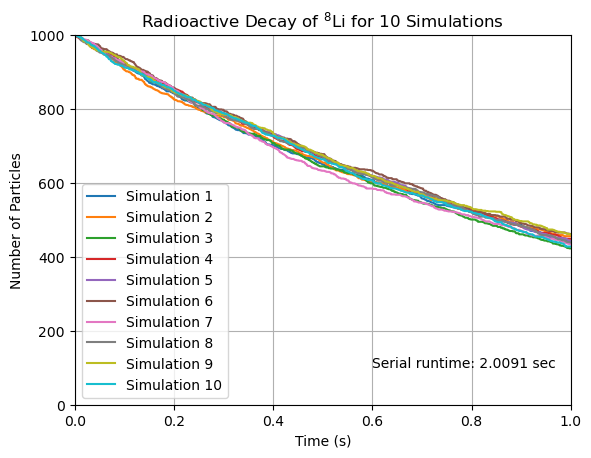

In [3]:
num_simulations = 10

# Record execution time
start_time = time.time()

# Run simulations in serial
for _ in range(num_simulations):
    time_points, undecayed_particles, decayed_particles = metropolis_decay(N0, half_life, max_time, dt)
    plt.plot(time_points, undecayed_particles, label=f'Simulation {_ + 1}')

plt.xlabel('Time (s)')
plt.ylabel('Number of Particles')
plt.title(f'Radioactive Decay of $^8$Li for {num_simulations} Simulations')
plt.xlim(0, max_time)
plt.ylim(0, N0)
plt.grid()
plt.legend()

end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time for {num_simulations} serial simulations: {execution_time:.4f} seconds")
plt.text(0.6, 100, f'Serial runtime: {execution_time:.4f} sec')
plt.show()


(c) (15 points) Use the multiprocessing module, specifically Process (), to parallelize the code that you wrote in part (b). Change the random seed and repeat the decay process 10 times, plot the number of nuclei versus time to ensure that you get a similar result to part (b), and record the time it takes for your computer to execute the parallelized code. Hint: To parallelize your code, it may be helpful to define a "worker" function that will save the output from your function in part (a). You can then add the data to a Manager() to create a dictionary.

Total execution time for 10 parallel simulations: 1.0845 seconds


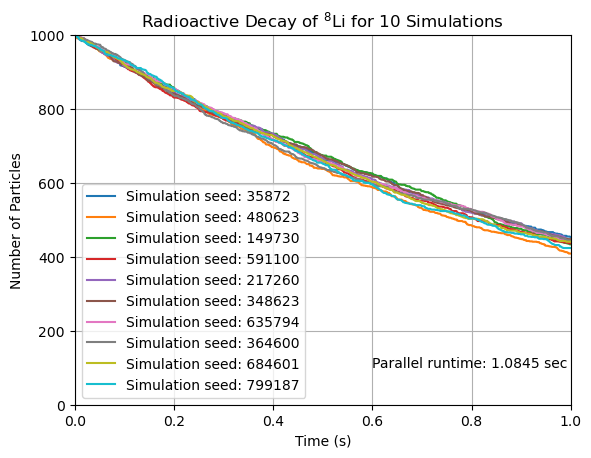

In [4]:
# Worker function for parallel simulations
def worker(seed, N0, half_life, max_time, dt, output_dict):
    np.random.seed(seed)
    result = metropolis_decay(N0, half_life, max_time, dt)
    output_dict[seed] = result

num_processes = os.cpu_count()

# Run simulations in parallel
manager = mp.Manager()
output_dict = manager.dict()

# Record execution time
start_time = time.time()

# Processes with a random seed
processes = [mp.Process(target=worker, args=(np.random.randint(1, 1000000), N0, half_life, max_time, dt, output_dict)) for _ in range(num_simulations)]

for p in processes:
    p.start()

for p in processes:
    p.join()

all_time_points = []
all_undecayed_particles = []
all_decayed_particles = []

for seed, result in output_dict.items():
    all_time_points.append(result[0])
    all_undecayed_particles.append(result[1])
    all_decayed_particles.append(result[2])
    plt.plot(result[0], result[1], label=f'Simulation seed: {seed}')

plt.xlabel('Time (s)')
plt.ylabel('Number of Particles')
plt.title(f'Radioactive Decay of $^8$Li for {num_simulations} Simulations')
plt.xlim(0, max_time)
plt.ylim(0, N0)
plt.grid()
plt.legend()

end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time for {num_simulations} parallel simulations: {execution_time:.4f} seconds")
plt.text(0.6, 100, f'Parallel runtime: {execution_time:.4f} sec')
plt.show()


## Problem 2 (run and include as script)
See HW6-Nbody0.py for a serial version to parallelize.

In this notebook below, include your particle position plot at the final time and your parallel efficiency code and plot here.

Parallel N-body Solver (45 points total): Here you will parallelize an N-body solver that follows the 3D dynamics of a purely gravitational system. You can find the serial code, called HW6-Nbody0.py, in the github repository that you clone. It has comments (saying MODIFY HERE) specifying where you need to add parallelism with MPI collective calls. Your code should be able to run in serial (1 core) and in parallel. First we will describe the system setup and underlying physics.

Consider a set of $N=1000$ point masses each with a mass $m_{i}=1 \mathrm{~kg}$. They are organized in a sphere of radius $r_{0}=1 \mathrm{~m}$ with a uniform density. The system is rotating with tangential velocities that are not sufficient to keep it from collapsing. The force $\vec{F}_{i j}$ and thus acceleration $\vec{a}_{i j}$ on the $i^{\text {th }}$ particle from the $j^{\text {th }}$ particle is

$$
\vec{F}_{i j}=\frac{G m_{i} m_{j} \hat{r}_{i j}}{\left|\vec{r}_{i j}\right|^{2}},
$$

where $G$ is the gravitational constant and $\vec{r}_{i j}=\vec{r}_{j}-\vec{r}_{i}$. The total force $\vec{F}_{i}$ experienced by the $i^{\text {th }}$ particle is the sum of all other particles

$$
\vec{F}_{i}=\sum_{j, j \neq i}^{N} \vec{F}_{i j}=m_{i} \vec{a}_{i}
$$

We initialize the uniform sphere with solid body rotation. The particle positions are uniformly distributed within a sphere of radius $r_{0}=1 \mathrm{~m}$. The circular ($\theta$-component) velocity $V_{c}$ in a uniform sphere of the $i^{\text {th }}$ particle is given by

$$
V_{c, i}=\sqrt{\frac{G M_{\mathrm{enc}}}{r_{i}}}=\sqrt{\frac{G}{r} \times M_{\mathrm{total}}\left(\frac{r_{i}}{r_{0}}\right)^{3}}=\sqrt{\frac{G M_{\mathrm{total}} r_{i}^{2}}{r_{0}^{3}}}
$$

where $M_{\text {enc }}$ is the enclosed mass at radius $r_{i}, M_{\text {total }}$ is the total mass of the sphere, and the second expression comes from the mass scaling as volume. Our system is partially rotationally supported with $v_{\theta, i}=V_{c, i} / 2$. All other velocity components are zero.

The routine calc_accel computes the force and thus acceleration felt by each particle using Equations (3) and (4). The routine leapfrog evolves the system with the Leapfrog
(Verlet) Method with a timestep $\Delta t=10 \mathrm{~s}$ for a total of $5,000 \mathrm{~s}$. The sphere should contract and form an ellipsoid. The code contains timers so you can monitor the performance as you develop your parallelism and test on different numbers of cores.

Pro-tip: Prototype your code first with a small $N$ (e.g. 10) and 2 cores to test and debug before running at the final $N=1000$ value.

(a) (10 points) The initialization routine is only run on the root (rank-0) MPI process. Use an MPI collective call to share those data with the other MPI processes.


```python
# Given code
comm = MPI.COMM_WORLD
if comm.rank == 0:
    pos, vel = initialize(Npart)
else:
    pos, vel = None, None

# Modified code for sharing data
pos, vel = comm.bcast((pos, vel), root=0)
```

(b) (10 points) We will parallelize the force calculation by splitting the particle position list and sending them to each core. Modify the routine subrange to calculate the starting and ending indices of the portion associated with each MPI process (rank).


```python
def subrange(comm):
    # Serial code
    start = 0
    end = Npart

    # Parallel code
    size = comm.Get_size()  # Total number of processes
    rank = comm.Get_rank()  # Rank of the current process
    # Distribute the particles evenly across all processes accounting for non-divisible cases
    particles_per_process = Npart // size
    remainder = Npart % size
    if rank < remainder: #non-divisible case
        start = rank * (particles_per_process + 1)
        end = start + particles_per_process + 1
    else: # divisble case
        start = rank * particles_per_process + remainder
        end = start + particles_per_process
    return start, end, end-start
```

(c) (15 points) In the calc_accel routine, each core only works on a subset of the particles, effectively parallelizing it. However, the new acceleration arrays are local to the MPI process on which they were calculated. Use an MPI collective call to share these results with all MPI processes and then combine these results into a single array with a shape $=(\mathrm{N}, 3)$. Run your code with 2, 4, and 8 cores and report on the time elapsed and performance metrics reported. Plot the parallel efficiency as a function of number of cores in the Jupyter notebook with Problems 1 and 3. Also include the last particle position plot in the notebook.

```python
# Given code for serial
all_accel = accel

# Modified code for sharing results
all_accel = np.empty([Npart, 3])
comm.Allgather([accel, MPI.DOUBLE], [all_accel, MPI.DOUBLE])
```

#### Metrics
```bash
# serial run
mpirun -n 1 python HW6-Nbody0.py
Compute time elapsed = 341.775 seconds (1.5 steps/sec // 1.46e+03 particle-evolve/sec)

# 2 core parallel run
mpirun -n 2 python HW6-Nbody0.py
Compute time elapsed = 154.678 seconds (3.2 steps/sec // 3.23e+03 particle-evolve/sec)

# 4 core parallel run
mpirun -n 4 python HW6-Nbody0.py
Compute time elapsed = 84.622 seconds (5.9 steps/sec // 5.91e+03 particle-evolve/sec)

# 8 core parallel run - oversubscribed
mpirun -n 8 --oversubscribe python HW6-Nbody0.py
Compute time elapsed = 133.810 seconds (3.7 steps/sec // 3.74e+03 particle-evolve/sec)

```

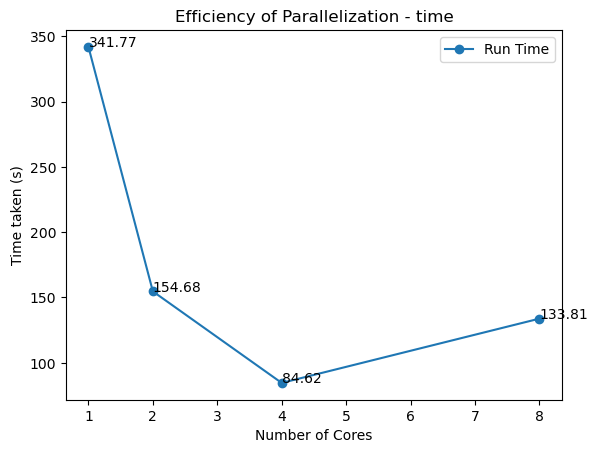

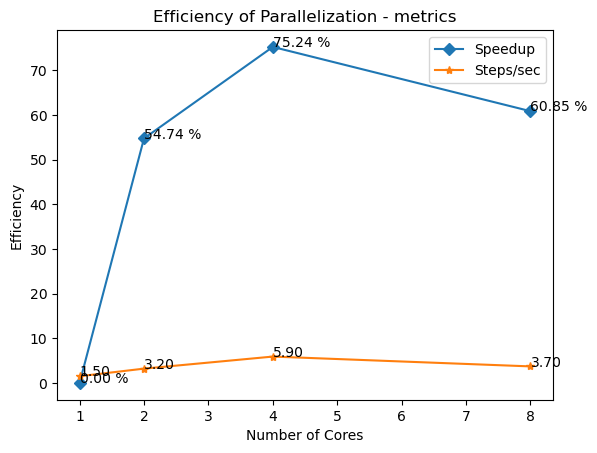

In [5]:
# Efficiency metrics
run_time = np.array([341.775, 154.678, 84.62, 133.810])
steps = np.array([1.5, 3.2, 5.9, 3.7])
num_cores = np.array([1, 2, 4, 8])
speedup = (run_time[0] - run_time) / run_time[0] * 100

plt.figure()
plt.plot(num_cores, run_time, marker='o', label='Run Time')
for i, txt in enumerate(run_time):
    plt.annotate(f'{txt:.2f}', (num_cores[i], run_time[i]))
plt.xlabel('Number of Cores')
plt.ylabel('Time taken (s)')
plt.title('Efficiency of Parallelization - time')
plt.legend()
plt.show()

plt.figure()
plt.plot(num_cores, speedup, marker='D', label='Speedup')
plt.plot(num_cores, steps, marker='*', label='Steps/sec')
for i, txt in enumerate(speedup):
    plt.annotate(f'{txt:.2f} %', (num_cores[i], speedup[i]))
for i, txt in enumerate(steps):
    plt.annotate(f'{txt:.2f}', (num_cores[i], steps[i]))
plt.xlabel('Number of Cores')
plt.ylabel('Efficiency')
plt.title('Efficiency of Parallelization - metrics')
plt.legend()
plt.show()

#### Final position

![Final position](positions-0500.png)

(d) (10 points) We only parallelized the for-loop in the force calculation but left most of the other code untouched. From inspecting the performance increases in part (c) and the nature of the algorithm(s), is it worthwhile to parallelize the other parts of the code? Justify your answer in a few sentences.

As we can see from the speed up percentage over the number of cores used, it is clear that we don't need to parallelize anythign else other than the loop. The loop is the most computationaly expensive part of the code and parallelizing it gives us the best speed up. The other parts of the code such as the calls and distributions are not as computationally expensive and parallelizing them would not give us a significant speed up, it would be a bad trade off between the time invested and the speedup produced. 

## Problem 3

Application question (10 points): In a couple of paragraphs (about 250 words), describe a system that interests you, whether it is time-dependent or time-independent, and which quantities are being computed / evolved. In particular, which numerical method (covered earlier in the semester) would you use to explore the system's structure and evolution (if time-dependent). Which parallel programming model would you choose to parallelize this code? How would you divide up the work among the cores? What are some performance bottlenecks that you could expect? You do not have to provide any code.

One system that particularly interests me is MHD simulations, a classic example of a time-dependent system which involves understanding the complex interactions of physical properties of fluids and gases like velocity, pressure, and temperature. To evolve such a system's structure and evolution, a numerical method like the Finite Volume Method (FVM) would be best as it discretizes the fluid domain into finite volumes, allowing the conservation equations to be solved numerically.

For parallelizing this code, MPI is a preferred choice as such simulations often deal with large spatial domains, requiring the distribution of computational workload across multiple processors on HPCs. MPI allows for efficient communication and coordination among distributed memory systems, making it well-suited for parallel simulations, especially when they are run on clusters of GPUs instead of CPUs and the primary goal is to rampu up the resolution without losing details. The workload can be divided among cores by decomposing the spatial domain into smaller subdomains, assigning each subdomain to a specific core. This way, each core independently computes the fluid dynamics within its allocated region, and communication occurs only at the boundaries of these subdomains while details for the central region of the blocks are stored per each node.

Potential performance bottlenecks may arise during inter-core communication, especially when exchanging information at subdomain boundaries. Efficient load balancing is crucial to prevent some cores from finishing their computations significantly earlier than others. Moreover, the overall simulation speedup might be limited by the necessity for frequent data exchanges. Optimizing communication patterns and minimizing data transfer between cores will be essential for achieving optimal performance in parallel MHD simulations.